# DQN

In [1]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os
%matplotlib inline

创建环境内物体对象的class

In [2]:
class gameOb():
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

创建GridWorld环境对应的class

In [3]:
class gameEnv():
    def __init__(self, size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        a = self.reset()
        plt.imshow(a, interpolation="nearest")
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(), 1, 1, 2, None, 'hero')
        self.objects.append(hero)
        goal = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal)
        hole = gameOb(self.newPosition(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole)
        goal2 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal2)
        hole2 = gameOb(self.newPosition(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole2)
        goal3 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal3)
        goal4 = gameOb(self.newPosition(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal4)
        state = self.renderEnv()
        self.state = state
        return state
    
    def moveChar(self, direction):
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        if direction == 0 and hero.y>=1:
            hero.y -= 1
        if direction == 1 and hero.y <=self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >=1:
            hero.x -= 1
        if direction ==3 and hero.x<=self.sizeX-2:
            hero.x += 1
        self.objects[0] = hero
        
    def newPosition(self):
        iterables = [range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if(objectA.x, objectA.y) not in currentPositions:
                currentPositions.append((objectA.x, objectA.y))
        for pos in currentPositions:
            points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]
    
    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else :
                others.append(obj)
        for other in others:
            if hero.x == other.x and hero.y ==other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(), 1, 1, 1, 1, 'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(), 1, 1, 0, -1, 'fire'))
                return  other.reward, False
        return 0.0, False
    
    def renderEnv(self):
        a = np.ones([self.sizeY+2, self.sizeX+2, 3])
        a[1:-1, 1:-1, :] = 0
        hero =None
        for item in self.objects:
            a[item.y+1:item.y+item.size+1, item.x+1:item.x+item.size+1, item.channel] = item.intensity
        b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp="nearest")
        c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp="nearest")
        d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp="nearest")
        a = np.stack([b,c,d], axis=2)
        return a
    
    def step(self,action):
        self.moveChar(action)
        reward, done = self.checkGoal()
        state = self.renderEnv()
        return state, reward, done

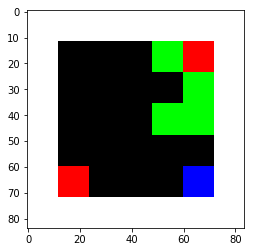

In [4]:
env = gameEnv(size=5)

DQN 网络结构

In [5]:
class Qnetwork():
    def __init__(self, h_size):
        self.scalarInput = tf.placeholder(shape=[None, 21168], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        self.conv1 = tf.contrib.layers.convolution2d(inputs=self.imageIn, num_outputs=32, 
                                                     kernel_size=[8,8], stride=[4,4], padding="VALID", biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(inputs=self.conv1, num_outputs=64, 
                                                     kernel_size=[4,4], stride=[2,2], padding="VALID", biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(inputs=self.conv2, num_outputs=64, 
                                                     kernel_size=[3,3], stride=[1,1], padding="VALID", biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(inputs=self.conv3, num_outputs=h_size, 
                                                     kernel_size=[7,7], stride=[1,1], padding="VALID", biases_initializer=None)
        
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW =  tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        #print("predict:", self.predict)
        
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot=tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)
        

实现Experience Replay 策略

In [6]:
class experience_buffer():
    def __init__(self, buffer_size=50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer)+len(experience) >=self.buffer_size:
            self.buffer[0:(len(self.buffer)+len(experience)-self.buffer_size)]=[]
        self.buffer.extend(experience)
        
    def sample(self, size):
        #print("size: ", size)
        #print(self.buffer)
        array = np.array(random.sample(self.buffer, size))
        #print(array)       
        
        return np.reshape(array, [size, 5])


In [7]:
def processState(states):
    return np.reshape(states, [21168])

In [8]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    #print("tfVars: ", type(tfVars))
    #print("total_vars: ", total_vars)
    op_holder = []
    for idx, var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder
 
def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

训练参数

In [9]:
batch_size = 32
update_freq = 4
y = .99
startE =  1
endE = 0.1
anneling_step = 10000
num_episodes = 10000
pre_train_steps = 10000
max_epLength = 50
load_model = False
path = "./model"
h_size = 512
tau = 0.001

In [10]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)
init = tf.global_variables_initializer()
trainables = tf.trainable_variables()
#print(len(trainables))

In [11]:
targetOps = updateTargetGraph(trainables, tau)

In [12]:
myBuffer = experience_buffer()
e= startE
stepDrop = (startE-endE)/anneling_step

rList = []
total_steps = 0
saver = tf.train.Saver()
if not os.path.exists(path):
    os.makedirs(path)

In [13]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print("Loading Model...")
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
   
    updateTarget(targetOps, sess)
    for i in range(num_episodes+1):
        episodeBuffer = experience_buffer()
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        while j< max_epLength:
            j += 1
            if np.random.rand(1) <e or total_steps<pre_train_steps:
                a = np.random.randint(0, 4)
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]
                
            s1, r,d = env.step(a)
            s1 = processState(s1)
            total_steps +=1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]), [1,5]))
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -=stepDrop
                if total_steps%(update_freq)==0 :
                
                    trainBatch = myBuffer.sample(batch_size)
                    #print("trainBatch:", type(trainBatch),trainBatch.shape, trainBatch[:,4]-1)
                    A = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    doubleQ = Q[range(batch_size), A]
                    #print("A", type(A),A.shape, A)
                    #print("Q", type(Q), A.shape, Q)
                    #print("doubleQ",len(doubleQ),  doubleQ)
                    end_multiplier = -(trainBatch[:,4] -1)
                    targetQ = trainBatch[:,2]+ (y*doubleQ*end_multiplier)
                    _ = sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), 
                                                            mainQN.targetQ: targetQ,
                                                            mainQN.actions:trainBatch[:,1]})
                    updateTarget(targetOps, sess)
                
            rAll +=r
            s =s1
            if d==True:
                break
        myBuffer.add(episodeBuffer.buffer)
        rList.append(rAll)
        if i>0 and i%25 ==0:
            print("episode", i, ", average reward of last 25 episode ", np.mean(rList[-25:]))
        if i>0 and i%1000 == 0:
            saver.save(sess, path+'/model-'+str(i)+'.cptk')
            print("saved model")
    saver.save(sess, path+'/model-' + str(i)+'.cptk')

episode 25 , average reward of last 25 episode  1.88
episode 50 , average reward of last 25 episode  2.56
episode 75 , average reward of last 25 episode  1.6
episode 100 , average reward of last 25 episode  2.48
episode 125 , average reward of last 25 episode  2.48
episode 150 , average reward of last 25 episode  2.0
episode 175 , average reward of last 25 episode  1.76
episode 200 , average reward of last 25 episode  2.56
episode 225 , average reward of last 25 episode  2.68
episode 250 , average reward of last 25 episode  2.16
episode 275 , average reward of last 25 episode  0.88
episode 300 , average reward of last 25 episode  1.72
episode 325 , average reward of last 25 episode  1.52
episode 350 , average reward of last 25 episode  0.6
episode 375 , average reward of last 25 episode  0.84
episode 400 , average reward of last 25 episode  1.16
episode 425 , average reward of last 25 episode  0.88
episode 450 , average reward of last 25 episode  1.04
episode 475 , average reward of la

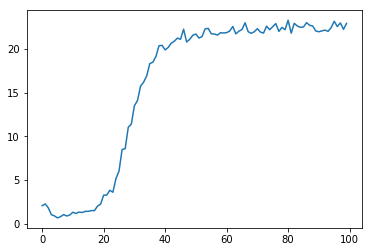

In [14]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)